## House Price Prediction

Os dados serão importados utilizando a biblioteca pandas que permite a manipulação dos dados utilizando tabelas.

In [78]:
# Importng pandas for data handling
import pandas as pd

# defining the default path of the files
path = "/home/esssfff/Documents/Github/Challenges/Datasets/"

# Load the data
df = pd.read_csv(path+"/data_scientist_test/house_sales.csv")

# This librarie is require to make the notebook clean
import warnings; warnings.simplefilter('ignore')

Vericando como os dados estão disponveis, se há valores faltantes.

In [79]:
# Check the size of dataset
print(df.shape)

(18448, 16)


In [80]:
# Check if there is a null values
print(df.isnull().sum())

price                       0
num_bed                     0
num_bath                    0
size_house                  0
size_lot                    0
num_floors                  0
is_waterfront               0
condition                   0
size_basement               0
year_built                  0
renovation_date             0
zip                         0
latitude                    0
longitude                   0
avg_size_neighbor_houses    0
avg_size_neighbor_lot       0
dtype: int64


Como mostrado no printout acima não há nenhum dado faltando, nesse caso não é necessário nenhuma técnica de pré-processamento para manipulação de dados faltantes.

O dataset é composto por mais de 18000 observações, utilizar o dataset inteiro resultaria em muito procesamento no treinamento do modelo, então serão retiradas amostras que refletem a população inteira, primeiro será analisado a coluna alvo.

In [81]:
# Analysing the price column
print(df['price'].describe())

count    1.844800e+04
mean     5.423624e+05
std      3.720135e+05
min      7.800000e+04
25%      3.218375e+05
50%      4.500000e+05
75%      6.480000e+05
max      7.700000e+06
Name: price, dtype: float64


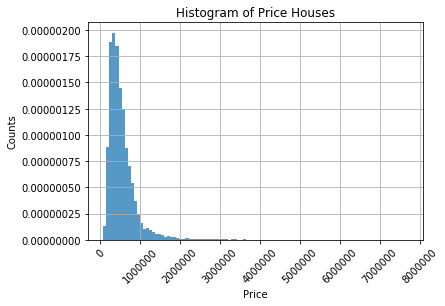

In [82]:
# Import librarie for visualization
import matplotlib.pyplot as plt

# the histogram of the price column
plt.hist(df['price'], bins=100, normed=1, alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Counts')
plt.title('Histogram of Price Houses')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Como é possivel analisar pelo histogram acima, a maioria dos preços das casa estão em uma faixa de preço, a distribuição dos preços segue quae uma distribuição gaussiana, se fizermos um amostragem dos dados para utilizar 10% dos dados, provavelmente algums valores de casas ficaram fora do modelo que será treinado, então nesse caso os dados serão dividos em 10000 faixas de preços, ou seja, a coluna de preço será dividida em 10000 faixas e dentro de cada faixa será retirada uma amostra de 10% dos dados, assim há a garantia que o modelo será treinando dentro do todas as faixas de preço disponiveis na coluna "price".

In [83]:
# Sampling the data
# Defing steps for each range
blocks = 10000
intersect = (df['price'].max() - df['price'].min()) / blocks

# Create a list with each ranges
prange = []
for value in range(0, blocks+1):
    prange.append(df['price'].min() + value * intersect)

sample_df = pd.DataFrame()
sample_size = 0.1

from itertools import tee

# function from itertools https://docs.python.org/3/library/itertools.html
# function picks pair of items in a list
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

for start, end in pairwise(prange):
    try:
        sample_df = sample_df.append(
            df[df['price'].between(start, end)].sample(
                frac=sample_size, replace=False, random_state=0))
    except:
        pass

Analisando novamente a coluna de "price" temos o seguinte Histograma

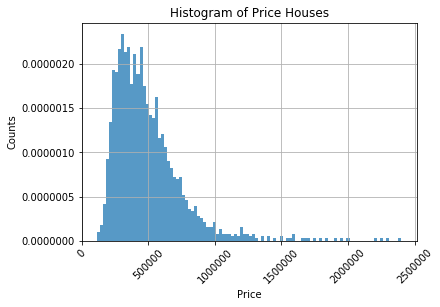

In [84]:
# Analysing the prince columns after sampling
plt.hist(sample_df['price'], bins=100, normed=1, alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Counts')
plt.title('Histogram of Price Houses')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

É possivel notar que distribuição do histograma mudou, agora os dados estão mais distruidos entre os valores, não é possivel que os dados sejam homogeneos entre todos os valores devido a quantidade de dados para cada faixa de preço, porém há a garantia que serão utilizados quase todos os valores de preço de casa no treinamento do modelo.

Como primeiro passo será treinando um modelo simples de regressão linear para analisar a precisão do modelo, esse ponto é necessário para guiar as passos na seleção das colunas e modelo final.

In [85]:
# Starting modeling
from sklearn.model_selection import train_test_split

# Split the date between data and target
X = sample_df.drop("price", axis=1)
y = sample_df["price"]

# split the date between train and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

# Train the firt model with LogisticRegression and default parameters
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)
lr.fit(Xtrain, ytrain)

# Score with default values
print("Precisão modelo Regressão Linear: {:.3f}".format(lr.score(Xtest, ytest)))

Precisão modelo Regressão Linear: 0.648


Com uma base sobre a precisão do modelo, será analisado a importância de cada coluna/feature dentro do modelo, a biblioteca eli5 possui uma ótima função que faz esse trabalho, ela analisa os dados fazendo um embaralhamento e calculando o impacto dessa alteração no modelo definido.

In [86]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lr).fit(Xtest, ytest)
eli5.show_weights(perm, feature_names = Xtest.columns.tolist())

Weight,Feature
0.6626 ± 0.0739,size_house
0.2412 ± 0.0467,latitude
0.0751 ± 0.0263,year_built
0.0580 ± 0.0109,avg_size_neighbor_houses
0.0412 ± 0.0250,num_bath
0.0383 ± 0.0111,num_bed
0.0356 ± 0.0092,longitude
0.0072 ± 0.0095,zip
0.0048 ± 0.0020,condition
0.0042 ± 0.0075,num_floors


Analisando as principais colunas/features, "size_house" diretamente relacionada ao preço, "latitude" é possivel inferir que casas que estão mais ao Sul tem o valor maior que as casas ao Norte, "year_built" casas construidas recentemente tem o valor maior que casas antigas. Agora analisando a contribuição das principais features.

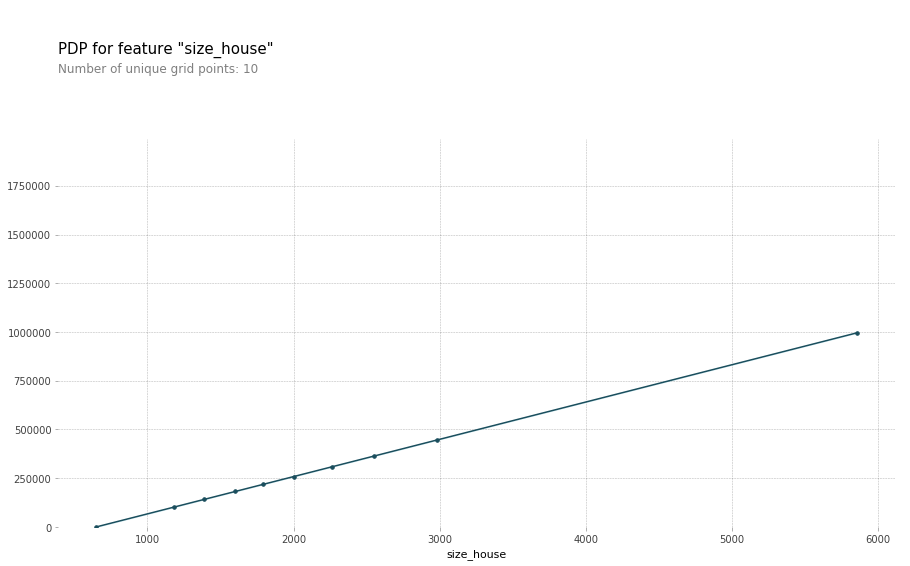

In [87]:
# Analysing the importance of main features
from pdpbox import pdp

pdp_goals = pdp.pdp_isolate(model=lr, 
                            dataset=Xtest, 
                            model_features=Xtest.columns.tolist(), 
                            feature='size_house')
pdp.pdp_plot(pdp_goals, 'size_house')
plt.show()

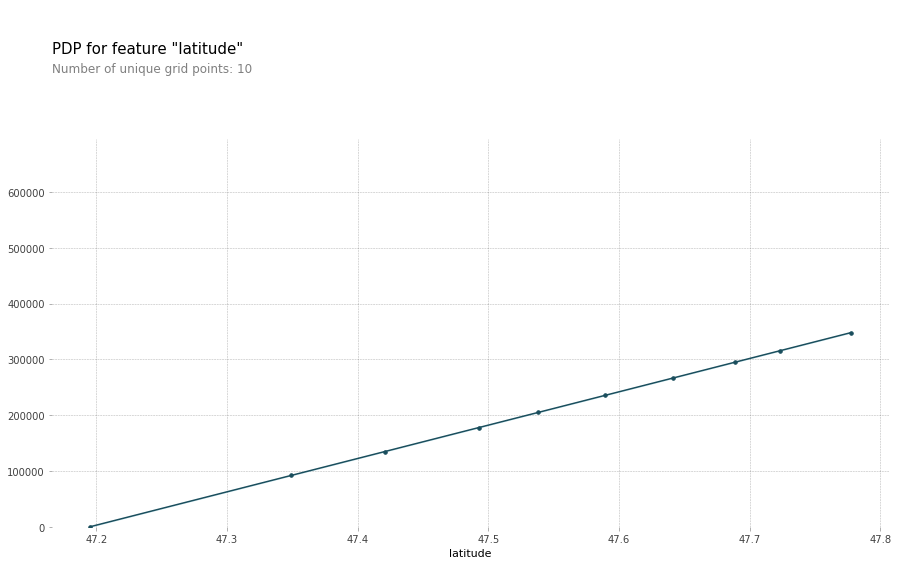

In [88]:
pdp_goals = pdp.pdp_isolate(model=lr, 
                            dataset=Xtest, 
                            model_features=Xtest.columns.tolist(), 
                            feature='latitude')
pdp.pdp_plot(pdp_goals, 'latitude')
plt.show()

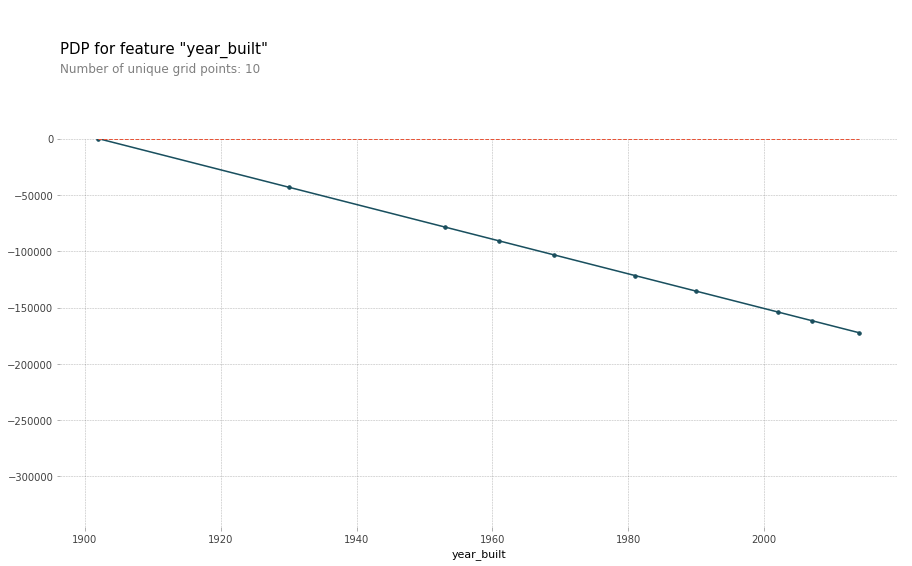

In [89]:
pdp_goals = pdp.pdp_isolate(model=lr, 
                            dataset=Xtest, 
                            model_features=Xtest.columns.tolist(), 
                            feature='year_built')
pdp.pdp_plot(pdp_goals, 'year_built')
plt.show()

Analisando o pdp.plot é possivel ver que as primeiras colunas/features fazem sentido com inferido anteriormente, porém em relação ao "year_built" temos uma contribuição negativa, casas mais novas não tem um valor maior mas sim menor, é possivel pensar que casas antigas tem um valor historico agregado, por isso tem o valor maior.

Com uma ideia inicial da importancia de cada coluna/feature serão treinados outros modelos, DecisionTreeRegressor e RandomForestRegressor, foram escolhidos modelos de regressão defido a caracteristica da coluna "price" que possui dados continuos e não classificatórios.

In [90]:
# Modeling with Decision Tree
X = sample_df.drop("price", axis=1)
y = sample_df["price"]

# split the date between train and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

# Import DecistionTreeClasifier
from sklearn.tree import DecisionTreeRegressor

# We set random_state=0 for reproducibility 
tree = DecisionTreeRegressor(random_state=0)

# fit and predict
tree.fit(Xtrain, ytrain)
ypred = tree.predict(Xtest)

# Model Accuracy: how often is the classifier correct?
print("Accuracy on training set DecisionTreeRegressor: {:.3f}".format(tree.score(Xtrain, ytrain))) 
print("Accuracy on test set DecisionTreeRegressor: {:.3f}".format(tree.score(Xtest, ytest)))

Accuracy on training set DecisionTreeRegressor: 1.000
Accuracy on test set DecisionTreeRegressor: 0.577


In [91]:
# Modeling with Random Forest
X = sample_df.drop("price", axis=1)
y = sample_df["price"]

# split the date between train and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# We set random_state=0 for reproducibility 
forest = RandomForestRegressor(random_state=0)

# fit and predict
forest.fit(Xtrain, ytrain)
ypred = forest.predict(Xtest)

# Model Accuracy: how often is the classifier correct?
print("Accuracy on training set RandomForestRegressor: {:.3f}".format(forest.score(Xtrain, ytrain))) 
print("Accuracy on test set RandomForestRegressor: {:.3f}".format(forest.score(Xtest, ytest)))

Accuracy on training set RandomForestRegressor: 0.953
Accuracy on test set RandomForestRegressor: 0.756


O modelo DecisionTree teve uma precisão perfeita no dataset de treinamento porém uma precisão pobre no dataset de teste, isso devido ao método de aprendizagem da DecisionTree que utilizando os valores padrões tem um overfitting causando um viés no modelo, ao contrário o modelo utilizando RandomForestRegressor que funciona fazendo uma coleção de DecisionTrees onde cada Tree se difere levemente das outras.

Para o modelo final será utilizado o modelo RandomForestRegressor, utilizando RFE (Recursive Feature Elimination) serão treinados vários modelos eliminando as colunas/features de acordo com a sua importãncia, o módulo RFE faz o cálculo diferente da Permutação utilizandas pelo pacote eli5, nesse cálculo é analisado a significancia da feature na precisão do modelo, também há a diferença entre o modelo utilizado na permutação, são esperado valores de importãncia de feature diferente dos apresentados anteriormente.

In [92]:
# Feature Selection
from sklearn.feature_selection import RFE

forest = RandomForestRegressor(random_state=0)
rfe = RFE(forest, n_features_to_select=1).fit(X, y)

print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X.columns)))

[(1, 'size_house'), (2, 'latitude'), (3, 'longitude'), (4, 'avg_size_neighbor_houses'), (5, 'year_built'), (6, 'zip'), (7, 'avg_size_neighbor_lot'), (8, 'size_lot'), (9, 'num_bath'), (10, 'size_basement'), (11, 'num_bed'), (12, 'condition'), (13, 'is_waterfront'), (14, 'num_floors'), (15, 'renovation_date')]


Como levantado anteriormente a importancia das features sofreu uma alteração, agora será feita a eliminação das colunas/features no treinamento do modelo calculando sua precisão.

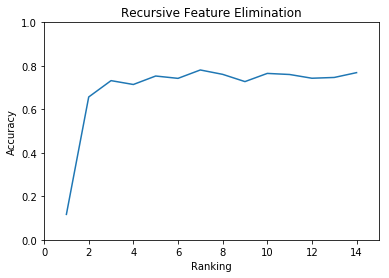

In [93]:
# Recursive Feature Elimination based on feature ranking
acc = []
rank = []

for value in range(1,max(rfe.ranking_)):
    
    # Split the date between data and target
    X = sample_df.drop("price", axis=1)
    y = sample_df["price"]
    
    features = rfe.ranking_ <= value

    names = X.columns
    names = list(names[features])
    X = X[names]

    # split the date between train and testing
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

    forest = RandomForestRegressor(random_state=0)
    forest.fit(Xtrain, ytrain)

    # Score with default values
    acc.append(forest.score(Xtest, ytest))
    rank.append(value)

plt.plot(rank, acc)
plt.xlabel("Ranking")
plt.xlim(xmin = 0, xmax = max(rfe.ranking_))
plt.ylabel("Accuracy")
plt.ylim(ymin = 0, ymax = 1)
plt.title("Recursive Feature Elimination")
plt.show()

Então temos a melhor precisão para o numero de features:

In [94]:
pd.merge(pd.DataFrame({"Features": sample_df.drop("price", axis=1).columns,"Ranking": rfe.ranking_}), 
         pd.DataFrame({"Accuracy": acc, "Ranking": rank})).sort_values(by=['Ranking'])

,Features,Ranking,Accuracy
2,size_house,1,0.116903
10,latitude,2,0.656832
11,longitude,3,0.731996
12,avg_size_neighbor_houses,4,0.714263
8,year_built,5,0.753223
9,zip,6,0.742445
13,avg_size_neighbor_lot,7,0.781020
3,size_lot,8,0.760933
1,num_bath,9,0.727580
7,size_basement,10,0.765221


Selecionando o melhor resultado de precisão, serão inseridos no modelo as seguintes colunas/features:

In [95]:
X = sample_df.drop("price", axis=1)
frank = [x for x, y in zip(rank, acc) if y == max(acc)][0]
selected_features = list(X.columns[rfe.ranking_ <= frank])
print(selected_features)

['size_house', 'year_built', 'zip', 'latitude', 'longitude', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot']


Depois de selecionado o modelo com cada feature o próximo passo é fazer o tunning dos paramêtros.

In [96]:
# Model tunning
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Defining datasets
X = sample_df.drop("price", axis=1)
X = X[selected_features]
y = sample_df["price"]

# We set random_state=0 for reproducibility
forest = RandomForestRegressor(random_state=0)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = forest, 
    param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
    random_state=42, n_jobs = -1)

rf_random.fit(Xtrain, ytrain)
xpred = rf_random.predict(Xtrain)
ypred = rf_random.predict(Xtest)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.2s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=20, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.1s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   0.6s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   0.2s
[CV] n_estimators=60, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=60, min_samples_sp

[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.2s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=80, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.4s
[CV] n_estimators=80, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=80, min

[CV]  n_estimators=90, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   0.5s
[CV] n_estimators=90, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=90, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   0.4s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   0.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=70, min_sample

[CV]  n_estimators=90, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   0.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   0.1s
[CV] n_estimators=60, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=60, min_sampl

[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.5s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   0.0s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   0.0s
[CV] n_estimators=20, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=20, min_samp

[CV]  n_estimators=90, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=True, total=   0.4s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   0.3s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   0.4s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   0.3s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=70, min_samples_sp

[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total=   0.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total=   0.6s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total=   0.6s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=70, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   0.1s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=70, min

[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total=   0.5s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total=   0.5s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True, total=   0.2s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=30, min_s

[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.1s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   0.1s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True 
[CV]  n_estimators=30, min_samples_split

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


E abaixo o resultado da predição juntamente com os melhores paramêtros de tunning

In [97]:
# Report the best parameters and the corresponding score
print("Best CV params", rf_random.best_params_)
print("Best CV accuracy", rf_random.best_score_)

Best CV params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': True}
Best CV accuracy 0.7498814994185222
